<a href="https://colab.research.google.com/github/sazio/NMAs/blob/main/src/Data_Loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploratory Data Analysis of Stringer Dataset 
@authors: Simone Azeglio, Chetan Dhulipalla , Khalid Saifullah 


Part of the code here has been taken from [Neuromatch Academy's Computational Neuroscience Course](https://compneuro.neuromatch.io/projects/neurons/README.html), and specifically from [this notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/neurons/load_stringer_spontaneous.ipynb)

# to do list

1. custom normalization: dividing by mean value per neuron
1a. downsampling: convolve then downsample by 5
2. training validation split: withhold last 20 percent of time series for testing
3. RNN for each layer: a way to capture the dynamics inside each layer instead of capturing extra dynamics from inter-layer interactions. it will be OK to compare the different RNNs. maintain same neuron count in each layer to reduce potential bias 
4. layer weight regularization: L2 
5. early stopping , dropout?

## Loading of Stringer spontaneous data



In [1]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Exploratory Data Analysis (EDA)

In [3]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [4]:
# functions 

def moving_avg(array, factor = 5):
  """Reducing the number of compontents by averaging of N = factor
  subsequent elements of array"""
  zeros_ = np.zeros((array.shape[0], 2))
  array = np.hstack((array, zeros_))

  array = np.reshape(array, (array.shape[0],  int(array.shape[1]/factor), factor))
  array = np.mean(array, axis = 2)

  return array

## Extracting Data for RNN (or LFADS)
The first problem to address is that for each layer we don't have the exact same number of neurons. We'd like to have a single RNN encoding all the different layers activities, to make it easier we can take the number of neurons ($N_{neurons} = 1131$ of the least represented class (layer) and level out each remaining class. 

In [5]:
# Extract labels from z - coordinate
from sklearn import preprocessing
x, y, z = dat['xyz']

le = preprocessing.LabelEncoder()
labels = le.fit_transform(z)
### least represented class (layer with less neurons)
n_samples = np.histogram(labels, bins=9)[0][-1]

In [6]:
### Data for LFADS / RNN 
import pandas as pd 
dataSet = pd.DataFrame(dat["sresp"])
dataSet["label"] = labels 

In [7]:
# it can be done in one loop ... 
data_ = []
for i in range(0, 9):
  data_.append(dataSet[dataSet["label"] == i].sample(n = n_samples).iloc[:,:-1])

dataRNN = np.zeros((n_samples*9, dataSet.shape[1]-1))
for i in range(0,9):
  dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]

## shuffling for training purposes

#np.random.shuffle(dataRNN)

In [8]:
unshuffled = np.array(data_)

In [9]:
#@title Convolutions code

# convolution moving average

# kernel_length = 50
# averaging_kernel = np.ones(kernel_length) / kernel_length

# dataRNN.shape

# avgd_dataRNN = list()

# for neuron in dataRNN:
#   avgd_dataRNN.append(np.convolve(neuron, averaging_kernel))

# avg_dataRNN = np.array(avgd_dataRNN)

# print(avg_dataRNN.shape)

In [10]:
# @title Z Score Code 


# from scipy.stats import zscore


# neuron = 500

# scaled_all = zscore(avg_dataRNN)
# scaled_per_neuron = zscore(avg_dataRNN[neuron, :])

# scaled_per_layer = list()

# for layer in unshuffled:
#   scaled_per_layer.append(zscore(layer))

# scaled_per_layer = np.array(scaled_per_layer)



# plt.plot(avg_dataRNN[neuron, :])
# plt.plot(avg_dataRNN[2500, :])
# plt.figure()
# plt.plot(dataRNN[neuron, :])
# plt.figure()
# plt.plot(scaled_all[neuron, :])
# plt.plot(scaled_per_neuron)
# plt.figure()
# plt.plot(scaled_per_layer[0,neuron,:])


In [11]:
# custom normalization

normed_dataRNN = list()
for neuron in dataRNN:
  normed_dataRNN.append(neuron / neuron.mean())
normed_dataRNN = np.array(normed_dataRNN)

# downsampling and averaging 

avgd_normed_dataRNN = moving_avg(normed_dataRNN, factor=5)

issue: does the individual scaling by layer introduce bias that may artificially increase performance of the network?

## Data Loader 


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# set the seed
np.random.seed(42)

# number of neurons 
NN = dataRNN.shape[0]

# let's use 270 latent components
ncomp = 10

In [15]:
# swapping the axes to maintain consistency with seq2seq notebook in the following code - the network takes all the neurons at a time step as input, not just one neuron

# avgd_normed_dataRNN = np.swapaxes(avgd_normed_dataRNN, 0, 1)
avgd_normed_dataRNN.shape

(10179, 1404)

In [16]:
frac = 5/6
#x1 = torch.from_numpy(dataRNN[:,:int(frac*dataRNN.shape[1])]).to(device).float().unsqueeze(0)
#x2 = torch.from_numpy(dataRNN[:,int(frac*dataRNN.shape[1]):]).to(device).float().unsqueeze(0)
x1 = torch.from_numpy(avgd_normed_dataRNN[:50,:]).to(device).float().unsqueeze(2)
x2 = torch.from_numpy(avgd_normed_dataRNN[:50,:]).to(device).float().unsqueeze(2)

NN1 = x1.shape[-1]
NN2 = x2.shape[-1]

In [17]:
x1.shape

torch.Size([50, 1404, 1])

In [27]:
class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    self.ncomp = ncomp
    # play with some of the options in the RNN!
    self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi, nonlinearity = 'tanh')
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x):
    x = x.permute(1, 0, 2)
    # print(x.shape)
    h_0 = torch.zeros(2, x.size()[1], self.ncomp).to(device)
    
    y, h_n = self.rnn(x, h_0)

    # print(y.shape)
    # print(h_n.shape)
    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    
    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    #z = F.softplus(self.fc(q), 10)
    # print(q.shape)
    z = self.fc(q).permute(1, 0, 2)
    # print(z.shape)
    return z, q

In [19]:
NN2

1

In [28]:
# we initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = x1.mean(axis = (0,1))

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer = torch.optim.Adam(net.parameters(), lr=.02)

In [ ]:
# forward check 
net(x1)

(tensor([[[0.8459],
          [0.9829],
          [1.0113],
          ...,
          [0.8708],
          [0.8506],
          [0.8611]],
 
         [[0.8900],
          [0.8911],
          [0.8882],
          ...,
          [0.8926],
          [0.8718],
          [0.8626]],
 
         [[0.8724],
          [0.8529],
          [0.8814],
          ...,
          [0.8817],
          [0.8866],
          [0.8575]],
 
         ...,
 
         [[0.8678],
          [0.8886],
          [0.8712],
          ...,
          [0.8766],
          [0.8976],
          [0.8676]],
 
         [[0.8832],
          [0.8506],
          [0.8820],
          ...,
          [0.8764],
          [0.8675],
          [0.8821]],
 
         [[0.8438],
          [0.8363],
          [0.8385],
          ...,
          [0.8735],
          [1.0125],
          [0.8889]]], device='cuda:0', grad_fn=<PermuteBackward>),
 tensor([[[-1.2445e-01,  1.6058e-01, -2.4614e-01,  ..., -6.2405e-02,
            4.6387e-01,  1.3908e-01],
     

## Training 

In [29]:
from tqdm.notebook import tqdm

In [30]:
# you can keep re-running this cell if you think the cost might decrease further

cost = nn.MSELoss()

niter = 100000
for k in tqdm(range(niter)):
  # the network outputs the single-neuron prediction and the latents
  z, y = net(x1)

  # our cost
  loss = cost(z, x2)

  # train the network as usual
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  if k % 250 == 0:
    print(f' iteration {k}, cost {loss.item():.4f}')

 iteration 0, cost 0.6120
 iteration 250, cost 0.0016
 iteration 500, cost 0.0009


KeyboardInterrupt: ignored

In [34]:
test, hidden = net(x1)

In [35]:
test.shape

torch.Size([50, 1404, 1])

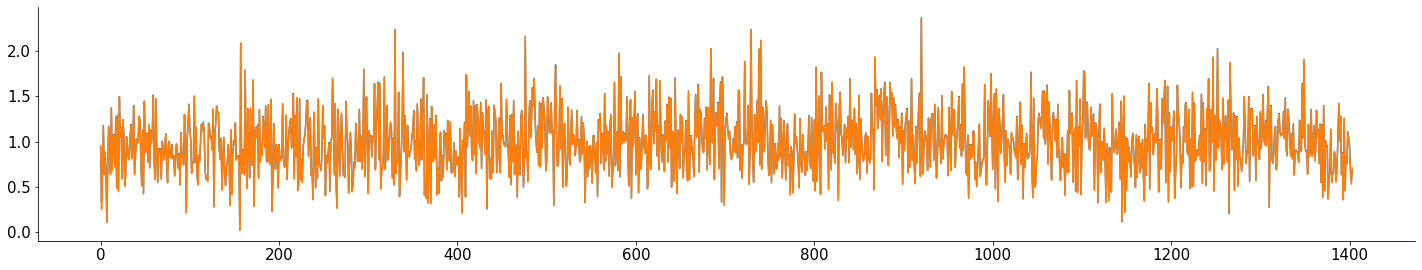

In [36]:
plt.plot(x1[25,:,0].cpu().detach().numpy())
plt.plot(test[25,:,0].cpu().detach().numpy())